### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from random import sample
import os

import torch, torch.nn as nn
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week06_rnn/names -O names

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
start_token = " "

#read_file = "/home/iris/paulshab/ShadLab7/shakespeare.txt"
read_file = "/home/iris/paulshab/ShadLab7/names"

with open(read_file) as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [3]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


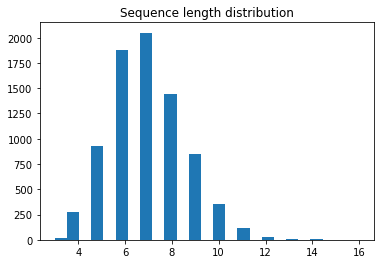

In [12]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

In [5]:
len(lines)

7944

In [4]:
chars = list(set(lines))
len(chars)

data_size, vocab_size = len(lines), len(chars)

char_to_indx = {ch:i for i, ch in enumerate(chars)}
indx_to_char = {i:ch for i, ch in enumerate(chars)}

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [5]:
#all unique characters go here

#tokens = <all unique characters in the dataset>

def split(word):
    char_list = []
    for char in word:
        char_list.append(char)
#         if char != ' ':
#             char_list.append(char)
    return char_list

tokens = []
for line in lines:
    char_list = split(line)
    for char in char_list:
        tokens.append(char)

tokens = set(tokens)

print(tokens)

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

#assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

{'m', 'O', 'b', 'c', 'l', 'y', '-', 'u', 'g', 'j', 't', 'q', 'J', 'E', 'v', 'r', 'z', 'D', 'B', 'X', 's', 'S', 'G', 'R', 'h', 'w', 'M', 'Y', 'L', 'K', 'V', 'n', 'U', 'N', 'T', 'k', 'x', 'o', 'H', ' ', 'W', 'f', 'p', 'Z', 'd', "'", 'P', 'A', 'a', 'F', 'I', 'Q', 'e', 'C', 'i'}
num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [6]:
#token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {ch:i for i, ch in enumerate(tokens)}
id_to_token = {i:ch for i, ch in enumerate(tokens)}

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [9]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[39 47  2 48  8 48 52  4 39]
 [39 22  4 37 15  5 39 39 39]
 [39 46 15 54 20 20 54 52 39]
 [39 22 54 37 14 48 31 31 52]]


## RNN from Scratch

- Why do you sample and not take the biggest prob?

<img src="IMG_6768.jpg" width=500>

<img src="./IMG_6769.jpg" width=500>

<img src="IMG_6770.jpg" width=500>

# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [21]:
len(tokens)
k = nn.Embedding(num_tokens, 10)

batch_ix = to_matrix(lines[:1])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix)

embedding = k(batch_ix)
embedding

tensor([[ 6, 40, 24, 33, 44, 33,  0, 12]])


tensor([[[ 2.2417,  0.7451, -1.3035, -1.6020, -1.0485,  1.9074, -0.4141,
           1.3691, -0.4117, -0.0320],
         [-0.2035,  0.4741,  0.0829, -0.4370,  1.7775, -1.2368, -0.8618,
           1.0661, -1.6345, -0.4146],
         [-1.2896, -0.3127, -0.4131,  1.2063, -0.4347,  1.7969, -1.5622,
           0.0623, -1.6734, -0.3407],
         [ 2.1481,  0.2812,  1.0802,  0.5862,  0.0598,  0.2400,  0.7990,
           0.1333, -0.6883,  0.1057],
         [-0.5329,  2.2235, -0.0752,  0.3196, -1.3173, -1.1512,  1.5680,
           0.9124,  1.2879, -0.6022],
         [ 2.1481,  0.2812,  1.0802,  0.5862,  0.0598,  0.2400,  0.7990,
           0.1333, -0.6883,  0.1057],
         [-0.8774, -0.7939, -1.6465, -0.2427,  0.0752,  0.8167, -1.0168,
           0.4705,  0.6958, -1.5691],
         [ 0.1045, -0.8414, -0.8063,  0.2777,  0.4459,  0.4962, -1.0370,
          -0.2371,  0.8984,  0.4905]]], grad_fn=<EmbeddingBackward>)

In [16]:
m = nn.Tanh()
soft_max = nn.Softmax(dim=1)

class RNN(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)   # encoder/decoder
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)   
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)          
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        #print("x_emb:", x_emb.shape)
        
        h_next = torch.cat((h_prev, x_emb), dim=1)
        #print("concat: ", h_next.shape)
        
        h_next = m(h_next @ self.rnn_update.weight.T)
        #print("h_next", h_next.shape)
        
        #compute logits for next character probs
        logits = h_next @ self.rnn_to_logits.weight.T
        #print("logits", F.log_softmax(logits, -1).shape)
 
        return h_next, F.log_softmax(logits, -1)
    
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

### Forward Pass for 1 Batch

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [15]:
rnn = RNN(embedding_size=25)

# get name matrix && convert to Tensor
batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print("batch: ", batch_ix.shape)

# get "name" matrix size
batch_size, max_length = batch_ix.size()
print("\nbatch_size, name_len: ", batch_size, max_length)

# get h0 state
hid_state = rnn.initial_state(batch_size)
print("\ninitial hidden state: ", hid_state.shape)

print("\nrnn update: ", rnn.rnn_update.weight.shape)

print("\nto_logits: ", rnn.rnn_to_logits.weight.shape)

# pass xt to RNN
for x_t in batch_ix.transpose(0,1):      # why transpose?
    print("\nht-1: ", hid_state.shape)
    print("xt: ", x_t.shape)
    emb = rnn(x_t, hid_state)
    print("rnn update: ", rnn.rnn_update.weight.shape)
    break



batch:  torch.Size([5, 24])

batch_size, name_len:  5 24

initial hidden state:  torch.Size([5, 64])

rnn update:  torch.Size([64, 89])

to_logits:  torch.Size([62, 64])

ht-1:  torch.Size([5, 64])
xt:  torch.Size([5])
rnn update:  torch.Size([64, 89])


## Calculate log P for all batches

In [21]:
def rnn_loop(rnn, batch_ix):
    
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        #print(hid_state)
    return torch.stack(logprobs, dim=1)

#rnn_loop(rnn, batch_ix)

In [17]:
batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(rnn, batch_ix)
print(len(logp_seq))

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

5


### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [18]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# take the actual letter in word from logits matrix
logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
print(logp_next.shape)

loss = -logp_next.mean()

torch.Size([5, 23, 1])


In [19]:
print("all log_p size", logp_seq.size())

print("next log_p size", predictions_logp.size())

print("\nactual batch next tokens\n", actual_next_tokens)

print("\n actual letter prob\n", logp_next.T)  # want to be minimal

#logp_next

all log_p size torch.Size([5, 24, 62])
next log_p size torch.Size([5, 23, 62])

actual batch next tokens
 tensor([[18, 26,  1,  4,  4, 49, 13, 26, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50],
        [13,  1, 50, 13,  7, 49, 50,  1,  4, 54,  5, 50, 20, 49, 17, 49, 13, 13,
         49, 30, 50,  1, 61]])

 actual letter prob
 tensor([[[-4.1656, -4.2230, -4.2230, -4.2230, -4.0996],
         [-4.1308, -4.1395, -4.1395, -4.1395, -3.9421],
         [-4.1171, -4.1149, -4.1149, -4.1149, -4.0612],
         [-4.2530, -4.0828, -4.0828, -4.0828, -4.0739],
         [-4.1403, -4.0759, -4.0759, -4.0759, -4.2083],
         [-3.9846, -4.0768, -4.0768,

In [20]:
loss.backward()

In [21]:
for w in rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

AssertionError: Loss is not differentiable w.r.t. a weight with shape torch.Size([64]). Check forward method.

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [20]:
#rnn = CharRNNCell()
opt = torch.optim.Adam(rnn.parameters())
history = []

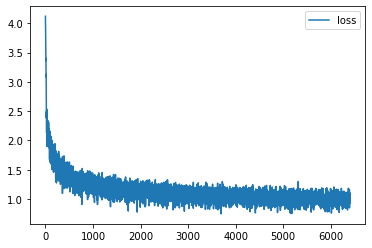

KeyboardInterrupt: 

In [21]:
for i in range(10000):
    
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(rnn, batch_ix)  # get log_P's for batch
    predictions_logp = logp_seq[:, :-1] # get next log_p's
    
    actual_next_tokens = batch_ix[:, 1:] # get actual next tokens

    # take the actual letter in word from logits matrix
    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    #compute loss
    loss = -logp_next.mean()
    
    # train with backprop  <YOUR CODE>
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [22]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]  # get sequance
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    #print("actual seq: ", x_sequence)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print("x_seq", x_sequence[:, i])
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print("x_seq", x_sequence[:, -1])
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        #print("p_next", p_next.shape)
        #print(p_next)
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print("next_ix", next_ix)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        #print("final seq", x_sequence)
     
    #print("print seq", x_sequence.data.numpy()[0])
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

print(generate_sample(rnn))

 So this writ you worntion deserved endees my insor by still 


In [23]:
for _ in range(20):
    print(generate_sample(rnn))

   all                                                       
 Mus of true happose I, fears,                               
 Lather's be poor teen's losurones preous a this ten pracess 
                                                             
   in mose couly thed wrink on my puty, by the love thosving 
 Mish                                                        
   Thesoild ouftles I so that Melfets less, if you is wince q
 My doin spee tatieed to be ase but I thou                   
 Dot pound,                                                  
 Ap wrent.                                                   
 Thine;                                                      
                                                             
   Kild, and that and,                                       
 Thy sporn, and in of bequequmits his I as thoray agand and k
   Yat,                                                      
 O, se so winds crowsil:                                     
 Time gi

In [155]:
k = torch.tensor([31], dtype=torch.int64)

hid_state = rnn.initial_state(batch_size=1)
h_next, logp =  rnn(k, hid_state)    # h_next and logits
print(logp.shape)

#model(k)

torch.Size([1, 55])


In [252]:
for _ in range(20):
    print(generate_sample(rnn, max_length=20, temperature=1))

 Puurita            
 Alkelde            
 Jesseo             
 Killa              
 Loryane            
 Traceo             
 Britta             
 Rokell             
 Matther            
 Dephen             
 Randon             
 Elex               
 Cat                
 Windred            
 Giffie             
 Zsila              
 Loty               
 Cliel              
 Vival              
 Inguenn            


In [ ]:
for _ in range(20):
    print(generate_sample(rnn, seed_phrase='Timur '))

In [ ]:
for _ in range(10):
    print(generate_sample(rnn))

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

# RNN Pytorch Implementation

In [41]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)    # tan[conact hid * W]
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        print("\nemebbedded", self.emb(x).shape)
        h_seq, h_last = self.rnn(self.emb(x)) # h_next, h_last
        print("\nh_next", h_seq.shape)
        print("\nh_last", h_last.shape)
        
        next_logits = self.hid_to_logits(h_seq)  
        print("\nnex logits", next_logits.shape)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    
model = CharRNNLoop()

#### Feed Batch

In [42]:
batch_ix = to_matrix(sample(lines, 5), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print("batch shape", batch_ix.shape)

logp_seq = model(batch_ix)

print("\nembedding: ", model.emb.weight.shape)
print("\nrnn_layer", model.rnn)
print("\nhidden to logits: ", model.hid_to_logits.weight.shape)


#print(logp_seq.shape)
#print(torch.exp(logp_seq[-1, -1, :]).sum())

logp_seq[0][-1].shape

batch shape torch.Size([5, 16])

emebbedded torch.Size([5, 16, 32])

h_next torch.Size([5, 16, 64])

h_last torch.Size([1, 5, 64])

nex logits torch.Size([5, 16, 55])

embedding:  torch.Size([55, 32])

rnn_layer RNN(32, 64, batch_first=True)

hidden to logits:  torch.Size([55, 64])


torch.Size([55])

#### Feed one Char

In [161]:
k = torch.tensor([31], dtype=torch.int64)
k = k.unsqueeze(0)
print(k.shape)

log_p = model(k)
print(log_p.shape)
torch.exp(log_p).sum()

torch.Size([1, 1])
torch.Size([1, 1, 55])


tensor(1.0000, grad_fn=<SumBackward0>)

#### Train

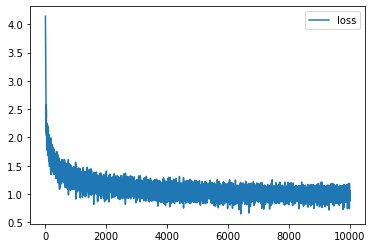

In [121]:
def train_model(model):
    opt = torch.optim.Adam(model.parameters())
    history = []
    
    for i in range(10000):
        batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        
        logp_seq = model(batch_ix)     # forward pass
        
        predictions_logp = logp_seq[:, :-1] # get next log_p's

        actual_next_tokens = batch_ix[:, 1:] # get actual next tokens

        # take the actual letter in word from logits matrix
        logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

        #compute loss
        loss = -logp_next.mean()

        # train with backprop 
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        history.append(loss.data.numpy())
        if (i+1)%100==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
        
        #return history
        
train_model(model) 

#### Predict

In [139]:
def rnn_predict(model, text='k', phrase_len=16):
    model.eval()
    
    words = text.split(' ')
    
    for i in range(0, phrase_len):
        x = [token_to_id[token] for token in words] 
        x = torch.tensor([x], dtype=torch.int64)

        y_pred = model(x)

        last_word_logits = y_pred[0][-1] 
        
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()   # why 2 softmax
        
        word_index = np.random.choice(len(last_word_logits), p=p)   # get word
        
        words.append(id_to_token[word_index])

    return ''.join(words)

for i in range(10):
    print(rnn_predict(model, text="k", phrase_len=40))

kerse,                                   
kit coming fathing, thy onech thy plamany
kin for the sud fortempon as end?        
kandife:                                 
king, my leving even your with name faud,
ken,                                     
kVsent not then and me is clent;         
knsh shuse dive hold, so that I thede.   
kes feuse,                               
kney,                                    


#### Forward Pass

In [253]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 8), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix.shape)

logp_seq = model(batch_ix)
print(torch.exp(logp_seq[-1:,-1:,:]).sum())
print(logp_seq.shape)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

torch.Size([8, 16])
tensor(1.0000, grad_fn=<SumBackward0>)
torch.Size([8, 16, 55])


# LSTM

In [214]:
class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units), torch.zeros(batch_size, self.num_units)
    
char_lstm = CharLSTMCell()

#### Forward Pass

In [22]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_lstm, batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

#### Train

In [217]:
def train_lstm(model, deep=False):
    opt = torch.optim.Adam(model.parameters())
    history = []
    
    for i in range(10000):
        batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        
        if deep == False:
            logp_seq = rnn_loop(model, batch_ix)     # forward pass
        else:
            logp_seq = lstm_rnn_loop(model, batch_ix)
        
        predictions_logp = logp_seq[:, :-1] # get next log_p's

        actual_next_tokens = batch_ix[:, 1:] # get actual next tokens

        # take the actual letter in word from logits matrix
        logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

        #compute loss
        loss = -logp_next.mean()

        # train with backprop  <YOUR CODE>
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        history.append(loss.data.numpy())
        if (i+1)%100==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
        

#train_lstm(char_lstm)

#### LSTM Predict

In [216]:
def predict(model, text=' ', phrase_len=16, deep=False):
    model.eval()
    
    words = text.split(' ')
    
    for i in range(0, phrase_len):
        x = [token_to_id[token] for token in words] 
        x = torch.tensor([x], dtype=torch.int64)
        #print("\n x", x)
        
        if deep==True:
            y_pred = lstm_rnn_loop(model, x)
        else:
            y_pred = rnn_loop(model, x)
        #print("\n y_pred", y_pred.shape)

        last_word_logits = y_pred[0][-1] 
        #print("\n logits", last_word_logits.shape)
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()   # why 2 softmax
        
        word_index = np.random.choice(len(last_word_logits), p=p)
        
        #print("\n sample letter", word_index)
        
        words.append(id_to_token[word_index])

    return ''.join(words)

for i in range(10):
    print(predict(char_lstm, text="h", phrase_len=50))

hve:                                               
h' Ish mights of goess greel more where wite       
hay,,                                              
hidin goon ston thich bodeds not foung,            
hIIWhe Bates I defiver paitnows woul;              
hR]n'n.                                            
hAMPvjghDdesi.                                     
h?Weesthrmfly buly tome.                           
h]:And the love and should;                        
h Who watches what shacule on shalosone asseep for 


### __Bonus quest: __ implement a model that uses 2 LSTM layers (the second lstm uses the first as input) and train it on your data.

# Deep RNN

In [149]:
class RNN_2Layer(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units1=64, rnn_num_units2=32):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn1 = nn.RNN(emb_size, rnn_num_units1, batch_first=True)       # tan[conact hid * W]
        self.rnn2 = nn.RNN(rnn_num_units1, rnn_num_units2, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units2, num_tokens)
        
    def forward(self, x):
        h_seq, _ = self.rnn1(self.emb(x)) # h_next
        j_seq, _ = self.rnn2(h_seq)
        next_logits = self.hid_to_logits(j_seq)              # 
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    
model = CharRNNLoop()

### Forward Pass

In [150]:
deep_rnn = RNN_2Layer()

# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 8), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix.shape)

logp_seq = deep_rnn(batch_ix)
print(torch.exp(logp_seq[-1:,-1:,:]).sum())
print(logp_seq.shape)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

torch.Size([8, 61])
tensor(1.0000, grad_fn=<SumBackward0>)
torch.Size([8, 61, 62])


### Train

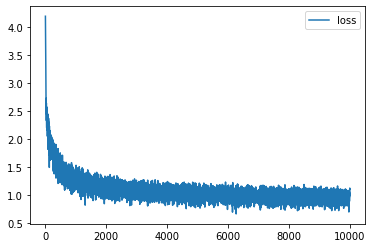

In [151]:
train_model(deep_rnn) 

### Predict

In [152]:
for i in range(10):
    print(rnn_predict(deep_rnn, text="k", phrase_len=40))

kings lie.                               
king eye I nage conguest fair            
kirghors no urins thou lecious thou did c
ksees,                                   
kXLS.                                    
kprossos in grave of men                 
khul doth self'Br thy self so natune in t
kings deest to stather, you'd hast nef do
khd two greace where con o, wht shoaraget
kios to mone bast.                       


# Deep LSTM

In [219]:
class LSTM_2Layer(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units1=64,rnn_num_units2=128):
        super(self.__class__,self).__init__()
        self.num_units1 = rnn_num_units1
        self.num_units2 = rnn_num_units2
        
        self.emb = nn.Embedding(num_tokens, embedding_size)
        
        self.lstm1 = nn.LSTMCell(embedding_size, rnn_num_units1)
        
        self.lstm2 = nn.LSTMCell(rnn_num_units1, rnn_num_units2)
        
        self.rnn_to_logits = nn.Linear(rnn_num_units2, num_tokens)
        
    def forward(self, x, prev_state1, prev_state2):
        (prev_h, prev_ch) = prev_state1
        (next_h, next_ch) = self.lstm1(self.emb(x), (prev_h, prev_ch))
        
        (prev_j, prev_cj) = prev_state2
        (next_j, next_cj) = self.lstm2(next_h, (prev_j, prev_cj))
        
        #return (next_h, next_ch), (next_j, next_cj)
        
        logits = self.rnn_to_logits(next_j)
        
        return (next_h, next_ch), (next_j, next_cj), F.log_softmax(logits, -1)
    
    def initial_state1(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units1), torch.zeros(batch_size, self.num_units1)
    
    def initial_state2(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units2), torch.zeros(batch_size, self.num_units2)
    
deep_lstm = LSTM_2Layer()

### RNN Loop

In [220]:
def lstm_rnn_loop(rnn, batch_ix):
    
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    
    hid_state1 = rnn.initial_state1(batch_size)
    hid_state2 = rnn.initial_state2(batch_size)
    
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state1, hid_state2, logp_next = rnn(x_t, hid_state1, hid_state2)  # <-- here we call your one-step code
        
        logprobs.append(logp_next)
    return torch.stack(logprobs, dim=1)

#rnn_loop(rnn, batch_ix)

batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = lstm_rnn_loop(deep_lstm, batch_ix)
logp_seq.shape

torch.Size([32, 61, 62])

### Forward Pass

In [221]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = lstm_rnn_loop(deep_lstm, batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

### Train

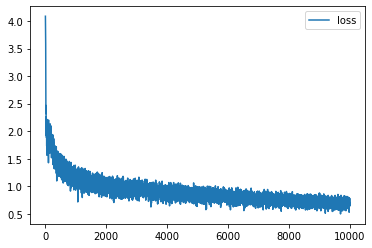

In [222]:
train_lstm(deep_lstm, deep=True)

### Predict

In [226]:
for i in range(20):
    print(predict(deep_lstm, text="l", phrase_len=50, deep=True))

ly,-                                               
lEPS Much inor up his fair comperet                
lindy!   He penerace wheremocy durwarning rockow:  
lix, stigh rowy sake humber world-wind             
lvxwD-for therefore so be vassing or call,         
linly too other shall own hath unheit,             
lztyhholst he vetter travel thee thou assure.      
lfoor from their sprity I winter place?            
l!-                                                
ls;                                                
lyhhShh One beauty in loss ox a perfeased          
llst I loves it is assamment must begind.          
llllbllR Which, her prove and all, but they die:   
lhRIII                                             
lmzoketh for thy sey being for perfect,            
lvMonpour the grament of swear'd                   
lakeoad, in then gentle dead sees to be show       
lokberakinned the voir still agoung to men,        
lyaII.                                             
lturs to lea